In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils.stacked_dataloader import StackedDataBunch
from musicautobot.utils.midifile import *

In [4]:
from fastai.text import *

## MultitaskTransformer Training

**NOTE** 
This notebook assumes you've already preprocessed `reddit_musicitem_data_save.pkl`.  
If you haven't, run `musicautobot/notebook/music_transformer/DataPreprocessing-Reddit.ipynb` first.

## End to end training pipeline 

1. Create and encode dataset
2. Initialize Transformer MOdel
3. Train
4. Predict

In [20]:
# Location of your midi files
midi_path = Path('data/midi')
# Location of preprocessed numpy files
s2s_numpy_path = Path('data/numpy/s2s')

# Location of models and cached dataset
data_path = Path('data/cached')

lm_data_save_name = 'reddit_musicitem_data_save.pkl'
s2s_data_save_name = 'reddit_multiitem_data_save.pkl'

[p.mkdir(parents=True, exist_ok=True) for p in [midi_path, s2s_numpy_path, data_path]];

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [6]:
# num_tracks = [1, 2] # number of tracks to support
cutoff = 5 # max instruments
min_variation = 3 # minimum number of different midi notes played
# max_dur = 128

In [7]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

128482

In [8]:
def process_metadata(midi_file):
    # Get outfile and check if it exists
    out_file = s2s_numpy_path/midi_file.relative_to(midi_path).with_suffix('.npy')
    out_file.parent.mkdir(parents=True, exist_ok=True)
    if out_file.exists(): return
    
    npenc = transform_midi(midi_file)
    if npenc is not None: np.save(out_file, npenc)

In [9]:
def transform_midi(midi_file):
    input_path = midi_file
    
    try: 
        if num_piano_tracks(input_path) not in [1, 2]: return None
        input_file = compress_midi_file(input_path, min_variation=min_variation, cutoff=2, supported_types=set([Track.PIANO])) # remove non note tracks and standardize instruments
        if not input_file: return None
    except Exception as e:
        if 'badly form' in str(e): return None # ignore badly formatted midi errors
        if 'out of range' in str(e): return None # ignore badly formatted midi errors
        print('Error parsing midi', input_path, e)
        return None
        
    # Part 2. Compress rests and long notes
    stream = file2stream(input_file) # 1.
    try:
        chordarr = stream2chordarr(stream) # 2. max_dur = quarter_len * sample_freq (4). 128 = 8 bars
    except Exception as e:
        print('Could not encode to chordarr:', input_path, e)
#         print(traceback.format_exc())
        return None
    
    chord_trim = trim_chordarr_rests(chordarr)
    chord_short = shorten_chordarr_rests(chord_trim)
    delta_trim = chord_trim.shape[0] - chord_short.shape[0]
#     if delta_trim > 300: 
#         print(f'Removed {delta_trim} rests from {input_path}. Skipping song')
#         return None
    chordarr = chord_short
    
    # Only 2 piano parts allowed
    if len(chordarr.shape) != 3: return None
    _,num_parts,_ = chordarr.shape
    if num_parts != 2: return None
    
    # Individual parts must have notes
    parts = [part_enc(chordarr, i) for i in range(num_parts)]
    for p in parts: 
        if not is_valid_npenc(p, min_notes=8, input_path=input_path): return None
        
    # order by melody > chords
    p1, p2 = parts
    m, c = (p1, p2) if avg_pitch(p1) > avg_pitch(p2) else (p2, p1) # Assuming melody has higher pitch
    
    return np.array([m, c])

In [10]:
# # sanity check
import random
for r in random.sample(midi_files, 10):
    process_metadata(r)

In [11]:
def timeout_func(data, seconds):
    print("Timeout:", seconds, data.get('midi'))

In [ ]:
processed = process_all(process_metadata, midi_files[:1000], timeout=120, timeout_func=timeout_func)

### 2a. Create sequence to sequence dataset

In [10]:
def create_databunch(files, data_save_name, path=data_path):
    save_file = path/data_save_name
    if save_file.exists():
        data = load_data(path, data_save_name)
    else:
        save_file.parent.mkdir(exist_ok=True, parents=True)
        vocab = MusicVocab.create()
        processors = [S2SFileProcessor(), S2SPartsProcessor()]

        data = MusicDataBunch.from_files(files, path, processors=processors, 
                                          preloader_cls=S2SPreloader, list_cls=S2SItemList, dl_tfms=melody_chord_tfm)
        data.save(data_save_name)
    return data

In [11]:
s2s_numpy_files = get_files(s2s_numpy_path, extensions='.npy', recurse=True); len(s2s_numpy_files)

111

In [12]:
s2s_data = create_databunch(s2s_numpy_files, data_save_name=s2s_data_save_name); s2s_data

MusicDataBunch;

Train: LabelList (86 items)
x: S2SItemList
<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f8ed410>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f8f2bd0>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f844150>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f844250>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f844350>
y: LMLabelList
,,,,
Path: data/cached;

Valid: LabelList (8 items)
x: S2SItemList
<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f8edf90>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f8f2bd0>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f844110>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7fb79f844210>,<musicautobot.multitask_transformer.transform.MultitrackItem object at 0x7f

Structure

In [ ]:
xb, yb = s2s_data.one_batch(); xb

Key:
* 'c2m' = chord2melody translation
 * enc = chord
 * dec = melody
* 'm2c' = next word input
 * enc = melody
 * dec = chord
* 'pos' = timestepped postional encoding. Gives the model a better reference when translating

Note: MultitaskTransformer trains both translations ('m2c' and 'c2m') at the same time. 

### 2b. Create NextWord/Mask Dataset

Please run `Step 2` in `musicautobot/notebook/music_transformer/DataPreprocessing-Reddit.ipynb` to complete this step

In [21]:
lm_data = load_data(data_path, lm_data_save_name, 
                    bs=batch_size, bptt=bptt, encode_position=True,
                    dl_tfms=mask_lm_tfm_pitchdur)

In [ ]:
xb, yb = lm_data.one_batch(); xb

Key:
* 'msk' = masked input
* 'lm' = next word input
* 'pos' = timestepped postional encoding. This is in addition to relative positional encoding

Note: MultitaskTransformer trains on both the masked input ('msk') and next word input ('lm') at the same time.

The encoder is trained on the 'msk' data, while the decoder is trained on 'lm' data.



## 3. Initialize Model

In [23]:
# Load Data
batch_size = 2
bptt = 128

lm_data = load_data(data_path, lm_data_save_name, 
                    bs=batch_size, bptt=bptt, encode_position=True,
                    dl_tfms=mask_lm_tfm_pitchdur)

s2s_data = load_data(data_path, s2s_data_save_name, 
                     bs=batch_size//2, bptt=bptt,
                     preloader_cls=S2SPreloader, dl_tfms=melody_chord_tfm)

# Combine both dataloaders so we can train multiple tasks at the same time
data = StackedDataBunch([lm_data, s2s_data])

In [24]:
# Create Model
config = multitask_config(); config

learn = multitask_model_learner(data, config.copy())
# learn.to_fp16(dynamic=True) # Enable for mixed precision

In [25]:
learn.model

MultiTransformer(
  (encoder): MTEncoder(
    (embed): TransformerEmbedding(
      (embed): Embedding(312, 512, padding_idx=1)
      (pos_enc): PositionalEncoding()
      (beat_enc): Embedding(32, 512, padding_idx=0)
      (bar_enc): Embedding(1024, 512, padding_idx=0)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): MTEncoderBlock(
        (mha1): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=512, bias=True)
          (k_wgt): Linear(in_features=512, out_features=512, bias=True)
          (v_wgt): Linear(in_features=512, out_features=512, bias=True)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=512, out_features=512, bias=True)
        )
        (mha2): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=

# 4. Train

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('example')

## Predict

---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [15]:
# midi_files = get_files(midi_path, '.mid', recurse=True)
midi_file = Path('data/midi/notebook_examples/single_bar_example.mid'); midi_file

PosixPath('data/midi/notebook_examples/single_bar_example.mid')

Non midi note detected. Only returning valid portion. Index, seed 18 (28, 2)


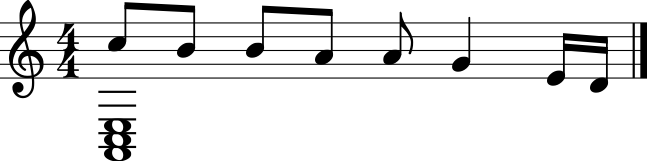

In [16]:
next_word = nw_predict_from_midi(learn, midi_file, n_words=20, seed_len=8); next_word.show()

Predicted past counter-part length. Returning early


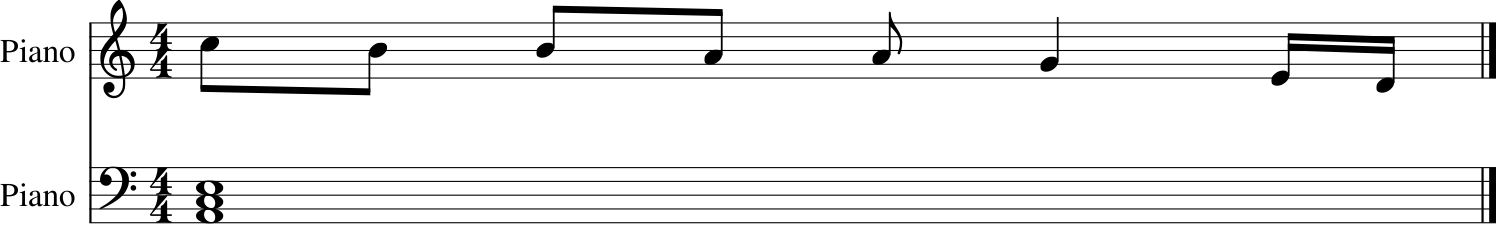

In [17]:
pred_melody = s2s_predict_from_midi(learn, midi_file, n_words=20, seed_len=4, pred_melody=True); pred_melody.show()

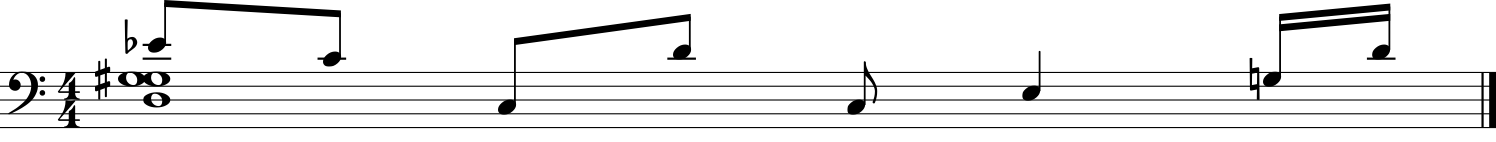

In [18]:
pred_notes = mask_predict_from_midi(learn, midi_file, predict_notes=True); pred_notes.show()